In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [1]:
# # wget不好用就直接手动下载解压下（文件文件被重命名为cats-and-dogs.zip），压缩文件有786M，
# !wget --no-check-certificate \
#     "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
#     -O "/tmp/cats-and-dogs.zip"
# # 解压文件
# local_zip = './tmp/cats-and-dogs.zip'
# zip_ref  = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('./tmp')
# zip_ref.close()

In [3]:
print(len(os.listdir('./tmp/PetImages/Cat/')))
print(len(os.listdir('./tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


In [4]:
# 生成这几个路径用来放训练和验证数据
try:
    os.mkdir('./tmp/cats-v-dogs')
    os.mkdir('./tmp/cats-v-dogs/training')
    os.mkdir('./tmp/cats-v-dogs/testing')
    os.mkdir('./tmp/cats-v-dogs/training/cats')
    os.mkdir('./tmp/cats-v-dogs/training/dogs')
    os.mkdir('./tmp/cats-v-dogs/testing/cats')
    os.mkdir('./tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [5]:
import os
import shutil

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


def create_dir(file_dir):
    if os.path.exists(file_dir):
        print('true')
        #os.rmdir(file_dir)
        shutil.rmtree(file_dir) #删除再建立
        os.makedirs(file_dir)
    else:
        os.makedirs(file_dir)
        
CAT_SOURCE_DIR = "./tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "./tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "./tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "./tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "./tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "./tmp/cats-v-dogs/testing/dogs/"
create_dir(TRAINING_CATS_DIR)
create_dir(TESTING_CATS_DIR)
create_dir(TRAINING_DOGS_DIR)
create_dir(TESTING_CATS_DIR)
    
split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

true
true
true
true
666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [8]:
print(len(os.listdir('./tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('./tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('./tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('./tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


In [3]:
# 建模
model = Sequential([
    # 16是输出特征图个数，input_shape是要将数据resize的大小
    Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

In [4]:
# 创建迭代器
TRAINING_DIR = "./tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.
# ,rotation_range=40 # 旋转40度 
# ,width_shift_range=0.2 # 左右平移
# ,height_shift_range=0.2 # 上下平移
# ,shear_range=0.2
# zoom_range=0.2 # 缩放，<1缩小，>1放大
# ,horizontal_flip=True # 翻转
# ,fill_mode='nearest' # 填充
)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR, # 文件路径
                                                    batch_size=100,
                                                    class_mode='binary', # 按标签定，二分类用binary，onehot用categorical
                                                    target_size=(64, 64)) # 和model的input对应

VALIDATION_DIR = "./tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(64, 64))

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [5]:
# fit_generator已经被fit代替了
history = model.fit(train_generator,
                      epochs=2,
                      verbose=1, # 记录日志
                      validation_data=validation_generator)

Epoch 1/2
 81/225 [=========>....................] - ETA: 34s - loss: 0.6862 - acc: 0.5648

D:\bag\Anaconda3-2021.05\envs\tf2\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 [==============================] - 62s 275ms/step - loss: 0.6246 - acc: 0.6456 - val_loss: 0.5340 - val_acc: 0.7436
Epoch 2/2
225/225 [==============================] - 35s 155ms/step - loss: 0.5213 - acc: 0.7393 - val_loss: 0.6896 - val_acc: 0.6616


<Figure size 432x288 with 0 Axes>

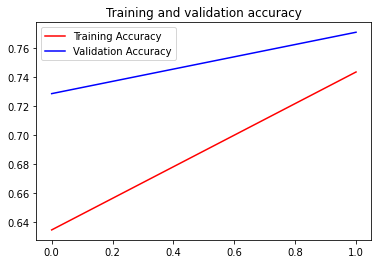

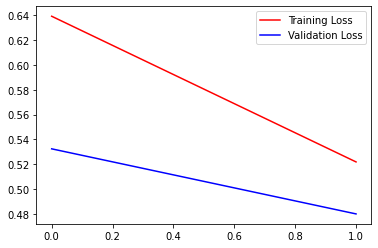

<Figure size 432x288 with 0 Axes>

In [16]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.legend()
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend()
plt.figure()


# Desired output. Charts with training and validation metrics. No crash :)

In [22]:
# predicting images
from tensorflow.keras.preprocessing import image
import numpy as np

path = './tmp/1.jpg'
img = image.load_img(path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

classes = model.predict(images, batch_size=10)
print(classes[0])
if classes[0]>0.5:
    print(" is a dog")
else:
    print(" is a cat")

[3.8294924e-21]
 is a cat
